In [2]:
import numpy as np
import torch
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchcnnbuilder.models import ForecasterBase
from pathlib import Path
import os
from torch.nn import functional as F
import mlflow
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# class MakeTimeSeriesData:
#     def __init__(self, path:str, window_size:int = 28*12, target_size:int=28*6, normalize = None) -> None:
#         self.path = Path(path)
#         self.normalize = normalize
#         self.window_size = window_size
#         self.target_size = target_size
#         self.x_train = dict()
#         self.y_train = dict()
#         self.x_val = dict()
#         self.y_val = dict()
#         self.x_test = dict()
#         self.y_test = dict()
#         self.x_train_tensor = dict()
#         self.y_train_tensor = dict()
#         self.x_val_tensor = dict()
#         self.y_val_tensor = dict()
#         self.x_test_tensor = dict()
#         self.y_test_tensor = dict()


#     def load(self):
#         feat = True
#         current = list()
#         for file in sorted(os.listdir(self.path)):
#             day = self._get_day(file)
#             year = self._get_year(file)
#             if year < 2020 and year < 2018:
#                 if day <= 28:
#                     current.append(self.path / Path(file))
#                 if feat and len(current) == 28*12:
#                     feat = False
#                     self.x_train[len(self.x_train.keys())] = current
#                     current = list()
#                 elif feat is False and len(current) == 28*6:
#                     feat = True
#                     self.y_train[len(self.y_train.keys())] = current
#                     current = list()
#             elif year > 2018:
#                 if day <= 28:
#                     current.append(self.path / Path(file))
#                 if feat and len(current) == 28*12:
#                     feat = False
#                     self.x_val[len(self.x_test.keys())] = current
#                     current = list()
#                 elif feat is False and len(current) == 28*6:
#                     feat = True
#                     self.y_val[len(self.y_test.keys())] = current
#                     current = list()
#             else:
#                 if day <= 28:
#                     current.append(self.path / Path(file))
#                 if feat and len(current) == 28*12:
#                     feat = False
#                     self.x_test[len(self.x_test.keys())] = current
#                     current = list()
#                 elif feat is False and len(current) == 28*6:
#                     feat = True
#                     self.y_test[len(self.y_test.keys())] = current
#                     current = list()

#     def get_data(self):
#         for index, data in tqdm(self.x_train.items()):
#             feat = [torch.from_numpy(np.load(path)) for path in data]
#             target = [torch.from_numpy(np.load(path)) for path in self.y_train[index]]
#             feat, target = torch.stack(feat), torch.stack(target)
#             feat, target = feat.to(torch.float32), target.to(torch.float32)
#             self.x_train_tensor[index] = feat
#             self.y_train_tensor[index] = target
#         for index, data in tqdm(self.x_test.items()):
#             feat = [torch.from_numpy(np.load(path)) for path in data]
#             target = [torch.from_numpy(np.load(path)) for path in self.y_test[index]]
#             feat, target = torch.stack(feat), torch.stack(target)
#             feat, target = feat.to(torch.float32), target.to(torch.float32)
#             self.x_test_tensor[index] = feat
#             self.y_test_tensor[index] = target
#         for index, data in tqdm(self.x_val.items()):
#             feat = [torch.from_numpy(np.load(path)) for path in data]
#             target = [torch.from_numpy(np.load(path)) for path in self.y_test[index]]
#             feat, target = torch.stack(feat), torch.stack(target)
#             feat, target = feat.to(torch.float32), target.to(torch.float32)
#             self.x_test_tensor[index] = feat
#             self.y_test_tensor[index] = target
        
#     def _get_day(self, filename:str):
#         return int(filename.split('_')[1].split('.')[0][-2:])

#     def _get_year(self, filename:str):
#         return int(filename.split('_')[1].split('.')[0][:4])

In [4]:
class MakeTimeSeriesPerWeek:
    def __init__(self, path:str):
        self.path = Path(path)
        self.x_train = dict()
        self.y_train = dict()
        self.x_val = dict()
        self.y_val = dict()
        self.x_test = dict()
        self.y_test = dict()
        self.train = list()
        self.val = list()
        self.test = list()
    
    def _get_day(self, filename:str):
        return int(filename.split('_')[1].split('.')[0][-2:])

    def _get_year(self, filename:str):
        return int(filename.split('_')[1].split('.')[0][:4])
    
    def _get_month(self, filename:str):
        return int(filename.split('_')[1].split('.')[0][4:6])
    
    def _normalize(self, ar:np.array):
        return ar / ar.max().item()
    
    def _base_normalize(self, arr:np.array):
        return arr / 100
    
    def _form_data(self, inp_path:list):
        sum_im = None
        for im in inp_path:
            current = np.load(im)
            current = self._base_normalize(current)
            if sum_im is None:
                sum_im = current
            else:
                sum_im += current
        return sum_im / 7
    
    def _collect_average_info(self):
        feat_and_target = list()
        current = list()
        week = list()
        for file in tqdm(sorted(os.listdir(self.path))):
            day = self._get_day(file)
            month = self._get_month(file)
            if day > 28 and month == 2:
                continue
            else:
                week.append(self.path / Path(file))
                if len(week) == 7:
                    val = torch.tensor(self._form_data(week))
                    current.append(val)
                    week = list()
                    if len(current) == 72:
                        feat_and_target.append(current)
                        current = list()
        self.train = feat_and_target[:-2]
        self.val = feat_and_target[-2:-1]
        self.test = [feat_and_target[-1]]

    def _prepare_data(self, inp:list, feat:dict, target:dict):
        for val in tqdm(inp):
            feat[len(feat.keys())] = torch.stack(val[:48])
            target[len(target.keys())] = torch.stack(val[48:])

    def load(self):
        self._collect_average_info()
        self._prepare_data(self.train, self.x_train, self.y_train)
        self._prepare_data(self.val, self.x_val, self.y_val)
        self._prepare_data(self.test, self.x_test, self.y_test)

In [5]:
class IceDataset(Dataset):
    def __init__(self, x:dict, y:dict) -> None:
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x.keys())
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [6]:
class ModelArtic(nn.Module):
    def __init__(self, c_in, c_out, num_layers, batch_norm = False):
        super().__init__()
        self.batch_norm = batch_norm
        self.c_in = c_in
        self.c_out = c_out
        self.num_layers = num_layers
        if batch_norm:
            self.bn = nn.BatchNorm2d(4)
        self.model = ForecasterBase(input_size=[432, 432],
                       in_time_points=self.c_in,
                       out_time_points=self.c_out,
                       n_layers=self.num_layers)
    def forward(self, x):
        if self.batch_norm:
            x = self.bn(x)
        x = self.model(x)
        return x

In [7]:
def train(model, dataloader, current_epoch, lr = 1e-5):
    model.train()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.AdamW(lr=lr, params=model.parameters())
    loss_sum = 0.0
    count_objects = len(dataloader)

    for index, (x, y) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        x = x.to(device).to(torch.float32)
        y = y.to(device).to(torch.float32)
        logits = model(x)
        loss = F.l1_loss(logits, y)
        loss.backward()
        optimizer.step()
        global_step = current_epoch * len(dataloader) + index 
        mlflow.log_metric('MAE loss per step', loss.item(), step=global_step)
        loss_sum += loss   
    torch.cuda.empty_cache() 
    return loss_sum / count_objects

In [8]:
def evaluate(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    metric = 0

    with torch.no_grad():
        for data in tqdm(dataloader):
            x, y = data
            x  = x.to(device).to(torch.float32)
            y = y.to(device).to(torch.float32)
            preds = model(x)
            er = F.l1_loss(preds, y).item()
            metric += er
        torch.cuda.empty_cache()
    return metric / len(dataloader)

Training with 1 year duration in input, 6 months as output

In [9]:
data_split = MakeTimeSeriesPerWeek(r'D:\Arctic_project\dataset\osisaf')
data_split.load()

100%|██████████| 1/1 [00:00<00:00, 44.05it/s]


In [13]:
batch_size = 8

In [14]:
dataset_train = IceDataset(data_split.x_train, data_split.y_train)
dataset_test = IceDataset(data_split.x_test, data_split.y_test)
dataset_val = IceDataset(data_split.x_val, data_split.y_val)

In [15]:
dataloader_train = DataLoader(dataset=dataset_train, 
                              batch_size=batch_size)

dataloader_test = DataLoader(dataset=dataset_test,
                             batch_size=batch_size)

dataloader_val = DataLoader(dataset=dataset_val,
                            batch_size=batch_size)

In [12]:
model = ModelArtic(c_in=48, c_out=24, num_layers=5)

In [13]:
mlflow.set_experiment(experiment_name='model trained per week, min/max scaler')

<Experiment: artifact_location='file:///d:/Artic_model/mlruns/481099135687968271', creation_time=1750279794231, experiment_id='481099135687968271', last_update_time=1750279794231, lifecycle_stage='active', name='model trained per week, min/max scaler', tags={}>

In [14]:
epochs = 100

In [15]:
with mlflow.start_run() as run:
    params = {
        'epochs':epochs,
        'learning_rate': 1e-5,
        'batch_size':32,
        'loss_function': F.l1_loss,
        'metric_function': F.l1_loss,
        'optimizer': 'AdamW'
    }

    mlflow.log_params(params)
    
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary))
    mlflow.log_artifact('model_summary.txt')

    for epoch in range(epochs):
      print(f"Epoch {epoch + 1}")
      loss_epoch = train(model, dataloader_train, epoch)
      mlflow.log_metric('MAE avareage on epoch', loss_epoch, step=epoch)
      val_metric = evaluate(model, dataloader_val)
      mlflow.log_metric('MAE on validation after epoch', val_metric, step=epoch)
      print(f'Current metric on validation is {val_metric}')
    
    mlflow.pytorch.log_model(model, "model")

2025/06/24 12:58:24 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Epoch 1


4it [02:47, 41.80s/it]
100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


Current metric on validation is 0.09172898530960083
Epoch 2


4it [02:07, 31.97s/it]
100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


Current metric on validation is 0.0903225764632225
Epoch 3


4it [02:04, 31.07s/it]
100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


Current metric on validation is 0.08897720277309418
Epoch 4


4it [02:01, 30.41s/it]
100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


Current metric on validation is 0.08779118955135345
Epoch 5


4it [02:02, 30.53s/it]
100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


Current metric on validation is 0.08656088262796402
Epoch 6


4it [02:01, 30.31s/it]
100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Current metric on validation is 0.08533795922994614
Epoch 7


4it [02:01, 30.29s/it]
100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


Current metric on validation is 0.08407872170209885
Epoch 8


4it [02:00, 30.15s/it]
100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Current metric on validation is 0.08285963535308838
Epoch 9


4it [02:01, 30.30s/it]
100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


Current metric on validation is 0.08165889978408813
Epoch 10


4it [02:02, 30.58s/it]
100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Current metric on validation is 0.08064389228820801
Epoch 11


4it [02:02, 30.74s/it]
100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


Current metric on validation is 0.07964818924665451
Epoch 12


4it [02:01, 30.50s/it]
100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


Current metric on validation is 0.07859919965267181
Epoch 13


4it [02:02, 30.53s/it]
100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Current metric on validation is 0.07750559598207474
Epoch 14


4it [02:03, 30.94s/it]
100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


Current metric on validation is 0.07635511457920074
Epoch 15


4it [02:01, 30.32s/it]
100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


Current metric on validation is 0.07514777779579163
Epoch 16


4it [02:01, 30.27s/it]
100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


Current metric on validation is 0.07387444376945496
Epoch 17


4it [02:01, 30.25s/it]
100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Current metric on validation is 0.07250885665416718
Epoch 18


4it [02:01, 30.34s/it]
100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Current metric on validation is 0.0709662139415741
Epoch 19


4it [02:02, 30.72s/it]
100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Current metric on validation is 0.06939981877803802
Epoch 20


4it [02:02, 30.60s/it]
100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


Current metric on validation is 0.0676029622554779
Epoch 21


4it [02:01, 30.42s/it]
100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Current metric on validation is 0.06567034125328064
Epoch 22


4it [02:04, 31.10s/it]
100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Current metric on validation is 0.06360034644603729
Epoch 23


4it [02:03, 30.85s/it]
100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


Current metric on validation is 0.06117209419608116
Epoch 24


4it [02:03, 30.86s/it]
100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


Current metric on validation is 0.05897212028503418
Epoch 25


4it [02:05, 31.29s/it]
100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Current metric on validation is 0.05678899213671684
Epoch 26


4it [02:04, 31.13s/it]
100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


Current metric on validation is 0.05488354712724686
Epoch 27


4it [02:05, 31.34s/it]
100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Current metric on validation is 0.05284085124731064
Epoch 28


4it [02:05, 31.46s/it]
100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


Current metric on validation is 0.05095755308866501
Epoch 29


4it [02:06, 31.51s/it]
100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


Current metric on validation is 0.04944337159395218
Epoch 30


4it [02:06, 31.63s/it]
100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Current metric on validation is 0.04835532233119011
Epoch 31


4it [02:06, 31.51s/it]
100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


Current metric on validation is 0.04745529964566231
Epoch 32


4it [02:07, 31.85s/it]
100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Current metric on validation is 0.046740759164094925
Epoch 33


4it [02:03, 30.87s/it]
100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


Current metric on validation is 0.0459660142660141
Epoch 34


4it [02:04, 31.19s/it]
100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


Current metric on validation is 0.04523022100329399
Epoch 35


4it [02:17, 34.38s/it]
100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


Current metric on validation is 0.04480360075831413
Epoch 36


4it [02:08, 32.23s/it]
100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


Current metric on validation is 0.044050831347703934
Epoch 37


4it [02:06, 31.73s/it]
100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Current metric on validation is 0.043463680893182755
Epoch 38


4it [02:06, 31.66s/it]
100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Current metric on validation is 0.04300687462091446
Epoch 39


4it [02:06, 31.61s/it]
100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


Current metric on validation is 0.04249752312898636
Epoch 40


4it [02:06, 31.62s/it]
100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Current metric on validation is 0.04201393574476242
Epoch 41


4it [02:06, 31.64s/it]
100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Current metric on validation is 0.04163039103150368
Epoch 42


4it [02:04, 31.23s/it]
100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Current metric on validation is 0.040651507675647736
Epoch 43


4it [02:03, 30.95s/it]
100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


Current metric on validation is 0.04033048823475838
Epoch 44


4it [02:03, 30.91s/it]
100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Current metric on validation is 0.039397384971380234
Epoch 45


4it [02:03, 30.92s/it]
100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Current metric on validation is 0.03938383236527443
Epoch 46


4it [02:03, 30.92s/it]
100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Current metric on validation is 0.038388825953006744
Epoch 47


4it [02:03, 30.96s/it]
100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


Current metric on validation is 0.03820151835680008
Epoch 48


4it [02:03, 30.95s/it]
100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


Current metric on validation is 0.03741435706615448
Epoch 49


4it [02:03, 30.95s/it]
100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


Current metric on validation is 0.0378815196454525
Epoch 50


4it [02:03, 30.97s/it]
100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


Current metric on validation is 0.03669466823339462
Epoch 51


4it [02:03, 30.96s/it]
100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Current metric on validation is 0.03748850151896477
Epoch 52


4it [02:04, 31.02s/it]
100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


Current metric on validation is 0.036297935992479324
Epoch 53


4it [02:04, 31.00s/it]
100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Current metric on validation is 0.03677951544523239
Epoch 54


4it [02:03, 30.93s/it]
100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Current metric on validation is 0.03593704104423523
Epoch 55


4it [02:03, 30.92s/it]
100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Current metric on validation is 0.03631655126810074
Epoch 56


4it [02:04, 31.20s/it]
100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Current metric on validation is 0.03554896265268326
Epoch 57


4it [02:06, 31.66s/it]
100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


Current metric on validation is 0.035976339131593704
Epoch 58


4it [02:06, 31.65s/it]
100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Current metric on validation is 0.03507395088672638
Epoch 59


4it [02:06, 31.67s/it]
100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Current metric on validation is 0.0356823205947876
Epoch 60


4it [02:06, 31.66s/it]
100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


Current metric on validation is 0.035013891756534576
Epoch 61


4it [02:06, 31.63s/it]
100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


Current metric on validation is 0.03557784482836723
Epoch 62


4it [02:06, 31.67s/it]
100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Current metric on validation is 0.03474308177828789
Epoch 63


4it [02:06, 31.68s/it]
100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


Current metric on validation is 0.035332538187503815
Epoch 64


4it [02:06, 31.67s/it]
100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


Current metric on validation is 0.03470880910754204
Epoch 65


4it [02:06, 31.54s/it]
100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


Current metric on validation is 0.03510921820998192
Epoch 66


4it [02:06, 31.61s/it]
100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


Current metric on validation is 0.034520473331213
Epoch 67


4it [02:06, 31.61s/it]
100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Current metric on validation is 0.03499283269047737
Epoch 68


4it [02:06, 31.69s/it]
100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


Current metric on validation is 0.03444822505116463
Epoch 69


4it [02:06, 31.50s/it]
100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


Current metric on validation is 0.034785378724336624
Epoch 70


4it [02:06, 31.64s/it]
100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


Current metric on validation is 0.03446968272328377
Epoch 71


4it [02:06, 31.67s/it]
100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Current metric on validation is 0.034731823951005936
Epoch 72


4it [02:06, 31.69s/it]
100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Current metric on validation is 0.03441496193408966
Epoch 73


4it [02:05, 31.41s/it]
100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


Current metric on validation is 0.0345916673541069
Epoch 74


4it [02:06, 31.51s/it]
100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


Current metric on validation is 0.0342341773211956
Epoch 75


4it [02:06, 31.62s/it]
100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


Current metric on validation is 0.03435993567109108
Epoch 76


4it [02:06, 31.63s/it]
100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Current metric on validation is 0.034317560493946075
Epoch 77


4it [02:06, 31.50s/it]
100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Current metric on validation is 0.03428460285067558
Epoch 78


4it [02:05, 31.32s/it]
100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


Current metric on validation is 0.03410759195685387
Epoch 79


4it [02:04, 31.16s/it]
100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Current metric on validation is 0.03415204584598541
Epoch 80


4it [02:04, 31.23s/it]
100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


Current metric on validation is 0.034133028239011765
Epoch 81


4it [02:05, 31.28s/it]
100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


Current metric on validation is 0.03394990414381027
Epoch 82


4it [02:04, 31.10s/it]
100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Current metric on validation is 0.03399087116122246
Epoch 83


4it [02:04, 31.19s/it]
100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


Current metric on validation is 0.03385549038648605
Epoch 84


4it [02:04, 31.24s/it]
100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


Current metric on validation is 0.03384272754192352
Epoch 85


4it [02:04, 31.22s/it]
100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Current metric on validation is 0.033785123378038406
Epoch 86


4it [02:05, 31.28s/it]
100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


Current metric on validation is 0.033714111894369125
Epoch 87


4it [02:05, 31.27s/it]
100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Current metric on validation is 0.0337284691631794
Epoch 88


4it [02:04, 31.23s/it]
100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


Current metric on validation is 0.03356112539768219
Epoch 89


4it [02:04, 31.23s/it]
100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Current metric on validation is 0.03370616212487221
Epoch 90


4it [02:05, 31.26s/it]
100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Current metric on validation is 0.03362581133842468
Epoch 91


4it [02:04, 31.22s/it]
100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


Current metric on validation is 0.033476218581199646
Epoch 92


4it [02:05, 31.26s/it]
100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Current metric on validation is 0.03351432830095291
Epoch 93


4it [02:05, 31.27s/it]
100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


Current metric on validation is 0.033363211899995804
Epoch 94


4it [02:04, 31.23s/it]
100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


Current metric on validation is 0.03335264325141907
Epoch 95


4it [02:05, 31.26s/it]
100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


Current metric on validation is 0.03352707624435425
Epoch 96


4it [02:05, 31.28s/it]
100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


Current metric on validation is 0.033305149525403976
Epoch 97


4it [02:05, 31.26s/it]
100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


Current metric on validation is 0.03331609070301056
Epoch 98


4it [02:04, 31.09s/it]
100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


Current metric on validation is 0.03320079669356346
Epoch 99


4it [02:04, 31.24s/it]
100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


Current metric on validation is 0.03336351737380028
Epoch 100


4it [02:04, 31.24s/it]
100%|██████████| 1/1 [00:00<00:00,  7.09it/s]
2025/06/24 16:29:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Current metric on validation is 0.033053942024707794


2025/06/24 16:29:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/24 16:29:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [21]:
evaluate(model, dataloader_test)

100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


0.029474876821041107

In [22]:
torch.save(model.state_dict(), 'bets_model.pth')

In [ ]:
def visualize(model, dataloader: DataLoader, week_number:int = 0, count_weeks: int = 4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    preds = list()
    labels = list()
    with torch.no_grad():
        for data in dataloader:
            x, y = data
            x = x.to(device).to(torch.float32)
            y = y.to(device).to(torch.float32)
            logits = model(x)
            preds.append((logits * 100).squeeze(0).cpu())
            labels.append(y.squeeze(0).cpu())

# перевести предсказания в scale от 0 до 1.
# сделать визуализацию
# сделать в шкале blue в визуализации
# добавить метрик SSIM, PSNR
# перенести все в классы
    for i in range(4):
        week_number += i
        print('Ground truth visualization')
        plt.figure()
        plt.imshow(labels[0][week_number])
        plt.xlabel(f'date: week number is {week_number % 4 + 1}, month {round(week_number / 6)}, year {2020}')
        print('--------')
        print('Prediction')
        plt.figure()
        plt.imshow(preds[0][week_number])
        mae_diff = torch.mean((labels[0][week_number] - preds[0][week_number])).item()
        plt.xlabel(f'date: week number is {week_number % 4 + 1} month {round(week_number / 6)}, year {2020}, {mae_diff}')

Ground truth visualization
--------
Prediction
tensor(109.4261)


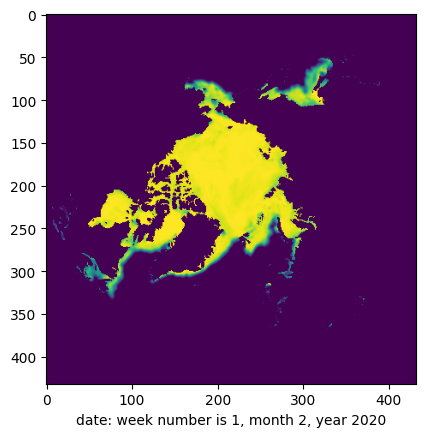

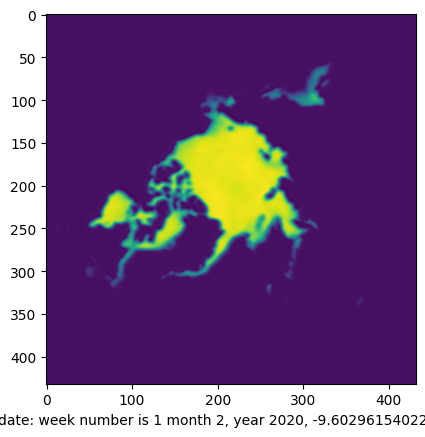

In [62]:
visualize(model, dataloader_test, week_number=12)